# GP Multiple runs on an arbitrary Symbolic Regression Problem.

To make our code truly general, it is important to be able to read data in from a file and perform Symbolic Regression on it.

One big step up from previous notebooks is that we need to store our data somewhere that the notebook can get at.

Install DEAP.

**Datasets**:

1.   salustowicz_input_file.csv (training) - https://drive.google.com/file/d/1SLOmZtnX7obHJ0XlwK-zn2R-RIW2_r2I/view?usp=sharing
2.   salustowicz_test_dataset.csv (testing)- https://drive.google.com/file/d/1hc0LPzhTjAmRnWwUXwRGDEnnRYAVsXF_/view?usp=sharing



In [64]:
!pip install deap

In [65]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


Clone the data folder from the class git repository and create a local copy for us to read. First, we need to create some space. You will be asked for confirmation by Google to do this.

In [66]:
import operator
import math
import random

import numpy

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import csv



import matplotlib.pyplot as plt

import itertools
import networkx as nx



Set our Genetic Programming parameters, one of which is now the number of runs.

In [67]:
# Genetic Programming constants:
POPULATION_SIZE = 300
P_CROSSOVER = 0.9
P_MUTATION = 0.1
MAX_GENERATIONS = 50
HALL_OF_FAME_SIZE = 1

N_RUNS = 30



Set the random seed.

In [68]:
RANDOM_SEED = 412
random.seed(RANDOM_SEED)

GP-Specific constants.

In [69]:
MIN_TREE_HEIGHT = 3
MAX_TREE_HEIGHT = 5
LIMIT_TREE_HEIGHT = 17
MUT_MIN_TREE_HEIGHT = 0
MUT_MAX_TREE_HEIGHT = 2

Read in the data.

In [70]:
def read_csv(filename):
    with open(filename) as f:
        reader = csv.reader(f)
        next(reader)
        data = []
        for row in reader:
            if all(cell.strip() != '' for cell in row):
                data.append([float(cell) for cell in row])
    return data

train_data = read_csv("salustowicz_input_file.csv")
test_data = read_csv("salustowicz_test_dataset.csv")


Define our fitness function.

In [71]:
def evalSymbReg(individual):
    func = toolbox.compile(expr=individual)
    sqerrors = []
    for row in train_data:
        x = row[0]
        y_true = row[1]
        try:
            y_pred = func(x)
            if math.isnan(y_pred) or math.isinf(y_pred):
                y_pred = 1e6
        except Exception:
            y_pred = 1e6
        sqerrors.append((y_true - y_pred)**2)
    return numpy.mean(sqerrors),

Define a protected division function.

In [72]:
def protectedDiv(left, right):
    try:
        if abs(right) < 1e-6:
            return 1.0
        return left / right
    except Exception:
        return 1.0

def psin(n):
    try:
        return math.sin(n)
    except Exception:
        return 0.0

def pcos(n):
    try:
        return math.cos(n)
    except Exception:
        return 0.0

def pow2(n):
    try:
        val = n**2
        if abs(val) > 1e6:
            return 1e6
        return val
    except Exception:
        return 1e6

def pexp(n):
    try:
        val = math.exp(n)
        if abs(val) > 1e6:
            return 1e6
        return val
    except Exception:
        return 1e6


Add our functions and terminals.

In [73]:
pset = gp.PrimitiveSet("MAIN", 1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(psin, 1)
pset.addPrimitive(pcos, 1)
pset.addPrimitive(pow2, 1)
pset.addPrimitive(pexp, 1)
pset.addEphemeralConstant("rand101", lambda: random.random())

Create our toolbox.

In [74]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=MIN_TREE_HEIGHT, max_=MAX_TREE_HEIGHT)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", evalSymbReg)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))


Now the magic happens and we run **N_RUNS** times. Always start with a small number of runs and generations to make sure that everything is working properly before you commit to a larger number. That way, if something goes horribly wrong, Python won't replicate it 30 times before giving you back control!

In [75]:
for r in range(0, N_RUNS):
    population = toolbox.population(n=POPULATION_SIZE)
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)


    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_fit.register("avg", numpy.mean)

    print(f"\nCurrently on run {r} of {N_RUNS}")

    population, logbook = algorithms.eaSimple(
        population,
        toolbox,
        cxpb=P_CROSSOVER,
        mutpb=P_MUTATION,
        ngen=MAX_GENERATIONS,
        stats=stats_fit,
        halloffame=hof,
        verbose=False
    )

    best = hof.items[0]
    print("Best Individual =", best)
    print("Best Fitness =", best.fitness.values[0])



Currently on run 0 of 30
Best Individual = protectedDiv(pcos(add(add(protectedDiv(ARG0, 0.9335852884454786), pcos(ARG0)), pcos(add(0.19372489209622434, ARG0)))), add(add(ARG0, pcos(ARG0)), pcos(ARG0)))
Best Fitness = 0.02719511404491187

Currently on run 1 of 30
Best Individual = protectedDiv(pcos(protectedDiv(add(ARG0, protectedDiv(0.7031546150952673, ARG0)), 0.43197168571966726)), add(add(ARG0, protectedDiv(0.7031546150952673, ARG0)), add(pcos(ARG0), pcos(sub(ARG0, 0.054061271915045506)))))
Best Fitness = 0.020002220630780155

Currently on run 2 of 30
Best Individual = mul(psin(sub(psin(pcos(ARG0)), protectedDiv(add(ARG0, 0.5149060563348669), add(ARG0, 0.5149060563348669)))), mul(psin(ARG0), pcos(ARG0)))
Best Fitness = 0.03309512049913481

Currently on run 3 of 30
Best Individual = pow2(pow2(mul(pcos(add(ARG0, 0.709949328528861)), pcos(protectedDiv(ARG0, 0.7875934729817612)))))
Best Fitness = 0.06269075906117343

Currently on run 4 of 30
Best Individual = mul(mul(sub(ARG0, psin(ARG0

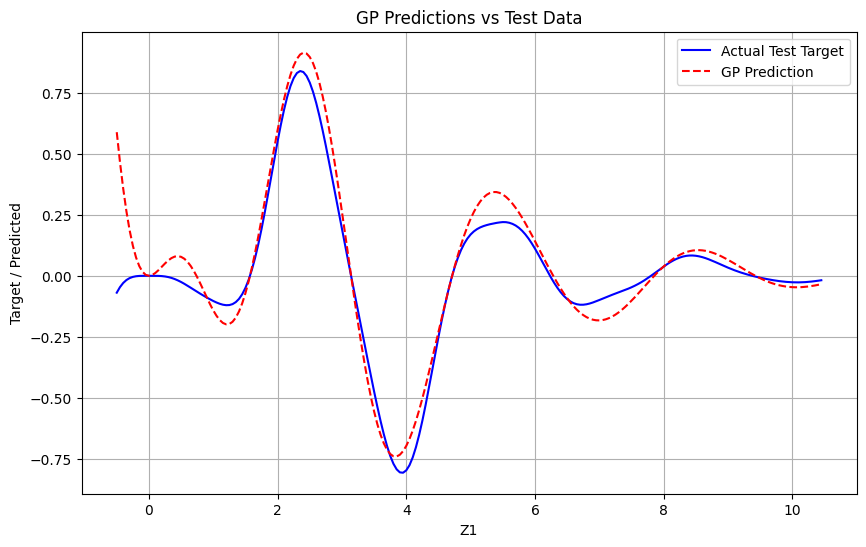

In [76]:
best_func = toolbox.compile(expr=best)

Z1_test = [row[0] for row in test_data]
TARGET_test = [row[1] for row in test_data]

PREDICTED_test = [best_func(z) for z in Z1_test]

plt.figure(figsize=(10,6))
plt.plot(Z1_test, TARGET_test, label="Actual Test Target", color='blue')
plt.plot(Z1_test, PREDICTED_test, label="GP Prediction", color='red', linestyle='--')
plt.xlabel("Z1")
plt.ylabel("Target / Predicted")
plt.title("GP Predictions vs Test Data")
plt.legend()
plt.grid(True)
plt.show()
